# Tutorial for the structural-color python package

Copyright 2016, Vinothan N. Manoharan

This file is part of the structural-color python package.

This package is free software: you can redistribute it and/or modify it under
the terms of the GNU General Public License as published by the Free Software
Foundation, either version 3 of the License, or (at your option) any later
version.

This package is distributed in the hope that it will be useful, but WITHOUT
ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS
FOR A PARTICULAR PURPOSE. See the GNU General Public License for more
details.

You should have received a copy of the GNU General Public License along with
this package. If not, see <http://www.gnu.org/licenses/>.

## Loading and using the package

To load, make sure you are in the top directory and do

In [1]:
import structcol
# or 
import structcol as sc

This will populate the structcol namespace with a few functions and classes.  You will probably find it easiest to keep all your calculations within a Jupyter notebook like this one.  The package itself contains only generic functions and classes (that is, it doesn't include any specific calculations of structural color spectra beyond the ones in this notebook).  For calculations in a notebook, you'll want to import some other packages too, like numpy and matplotlib:

In [2]:
%matplotlib inline 
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate

# require seaborn (not installed by default in Anaconda; comment out if not installed)
import seaborn as sns

## Using quantities with units

The structural-color package uses the [`pint`](http://pint.readthedocs.io/en/latest/) package to keep track of units and automatically convert them.  To define a quantity with units, use the `structcol.Quantity` constructor.  For example, to define a wavelength of 0.45 $\mu$m:

In [3]:
wavelen = sc.Quantity('0.45 um')

In [4]:
print(wavelen)
print(wavelen.dimensionality)

0.45 micrometer
[length]


Converting between units:

In [5]:
print(wavelen.to('m'))

4.5e-07 meter


Units work in numpy arrays, too:

In [6]:
wavelens = sc.Quantity(np.arange(450.0, 800.0, 10.0), 'nm')

In [7]:
print(wavelens.to('um'))

[ 0.45  0.46  0.47  0.48  0.49  0.5   0.51  0.52  0.53  0.54  0.55  0.56  0.57  0.58  0.59  0.6   0.61  0.62  0.63  0.64  0.65  0.66  0.67  0.68  0.69  0.7   0.71  0.72  0.73  0.74  0.75  0.76  0.77  0.78  0.79] micrometer


## Refractive index module

To use the refractive index module:

In [8]:
import structcol.refractive_index as ri

This module contains dispersion relations for a number of materials.  For example, to get the index of polystyrene at 500 nm, you can call

In [9]:
ri.n('polystyrene', sc.Quantity('500 nm'))

<Quantity(1.6032768445664916, 'dimensionless')>

You must give this function a quantity with units as the second argument.  If you give it a number, it will throw an error, rather than trying to guess what units you're thinking of.  You can also calculate the refractive index at several different wavelengths simultaneously, like this (using `wavelens` array from above):

In [10]:
n_particle = ri.n('polystyrene', wavelens)

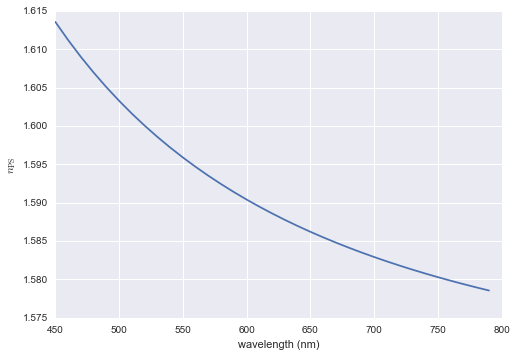

In [11]:
plt.plot(wavelens, n_particle)
plt.ylabel('$n_\mathrm{PS}$')
plt.xlabel('wavelength (nm)')

## Calculating a reflection spectrum
With the tools above we can calculate a reflection spectrum using the single-scattering model described in Magkiriadou, S., Park, J.-G., Kim, Y.-S., and Manoharan, V. N. “Absence of Red Structural Color in Photonic Glasses, Bird Feathers, and Certain Beetles” Physical Review E 90, no. 6 (2014): 62302. doi:10.1103/PhysRevE.90.062302

In [12]:
# uncomment the line below to time how long this calculation takes
# %%timeit 
from structcol import model

# parameters for our colloidal sample
volume_fraction = sc.Quantity(0.5, '')
radius = sc.Quantity('120 nm')

# wavelengths of interest
wavelength = sc.Quantity(np.arange(400., 800., 10.0), 'nm')

# calculate refractive indices at wavelengths of interest
n_particle = ri.n('polystyrene', wavelength)
n_matrix = ri.n('vacuum', wavelength)
n_medium = n_matrix

# now calculate the reflection spectrum, asymmetry parameter (g), and 
# transport length (lstar)
refl = np.zeros(wavelength.size)
g = np.zeros(wavelength.size)
# note the units explicitly assigned to the transport length; you
# must specify a length unit here
lstar = np.zeros(wavelength.size)*sc.ureg('um')
for i in range(wavelength.size):
    # the first element in the tuple is the reflection coefficient for 
    # unpolarized light.  The next two (which we skip) are the 
    # coefficients for parallel and perpendicularly polarized light.
    # Third is the asymmetry parameter, and fourth the transport length
    refl[i], _, _, g[i], lstar[i] = model.reflection(n_particle[i], n_matrix[i],
                                                     n_medium[i], wavelength[i],
                                                     radius, volume_fraction, 
                                                     thickness = sc.Quantity('15000.0 nm'),
                                                     theta_min = sc.Quantity('90 deg'))

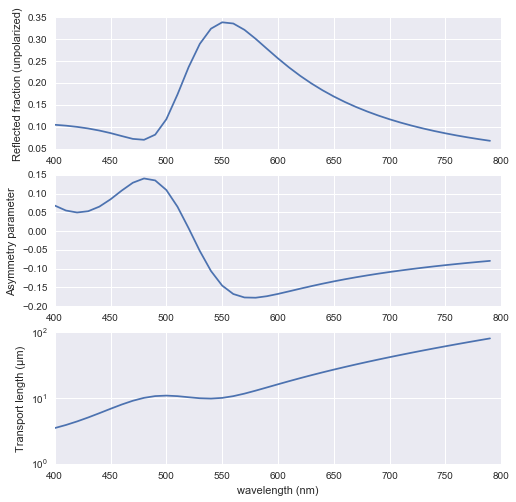

In [13]:
fig, (ax_a, ax_b, ax_c) = plt.subplots(nrows=3, figsize=(8,8))
ax_a.plot(wavelength, refl)
ax_a.set_ylabel('Reflected fraction (unpolarized)')

ax_b.plot(wavelength, g)
ax_b.set_ylabel('Asymmetry parameter')

ax_c.semilogy(wavelength, lstar)
ax_c.set_ylabel('Transport length (μm)')
ax_c.set_xlabel('wavelength (nm)')

Note that the asymmetry parameter becomes negative at the reflection peak (as expected, since light is preferentially backscattered), and, as a result, the transport length has a dip in the same wavelength region.

## Mie scattering module

Normally you won't need to use this model on its own, but if you want to, start with

In [14]:
from structcol import mie

Form factor calculation:

In [15]:
wavelen = sc.Quantity('450 nm')
n_matrix = ri.n('vacuum', wavelen)
n_particle = ri.n('polystyrene', wavelen)
radius = sc.Quantity('0.4 um')
m = sc.index_ratio(n_particle, n_matrix)
x = sc.size_parameter(wavelen, n_matrix, radius)

# must explicitly state whether angles are in radians or degrees
angles = sc.Quantity(np.linspace(0, np.pi, 1000), 'rad')
form_factor_par, form_factor_perp = mie.calc_ang_dist(m, x, angles)

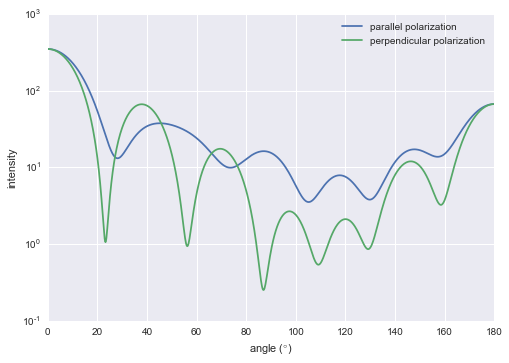

In [16]:
plt.semilogy(angles.to('deg'), form_factor_par, label='parallel polarization')
plt.plot(angles.to('deg'), form_factor_perp, label='perpendicular polarization')
plt.legend()
plt.xlabel('angle ($\degree$)')
plt.ylabel('intensity')

## Structure module

To use this module:

In [17]:
from structcol import structure

Here is an example of calculating structure factors with the Percus-Yevick approximation. The code is fully vectorized, so we can calculate structure factors for a variety of qd values and volume fractions in parallel:

In [18]:
qd = np.arange(0.1, 20, 0.01)
phi = np.array([0.15, 0.3, 0.45])
# this little trick allows us to calculate the structure factor on a 2d
# grid of points (turns qd into a column vector and phi into a row vector).
# Could also use np.ogrid
s = structure.factor_py(qd.reshape(-1,1), phi.reshape(1,-1))

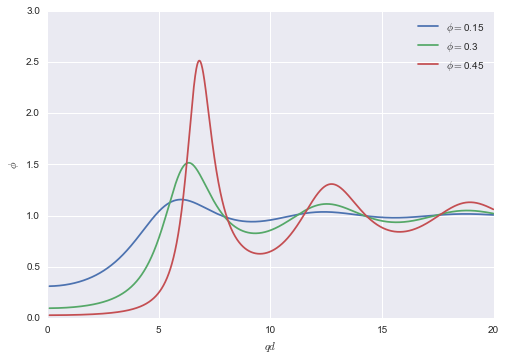

In [19]:
for i in range(len(phi)):
    plt.plot(qd, s[:,i], label='$\phi=$'+str(phi[i]))#, label='$phi='+phi[i]+'$')
plt.legend()
plt.xlabel('$qd$')
plt.ylabel('$\phi$')

## Development

Here are some tips for contributing code to the package:

1. Make sure that your code works in Python 3. You should write `print(x)` instead of `print x`, and you should check that any imported package is compatible with Python 3.

2. Wrap lines at 79 characters.  Use 4 spaces for each indent, and don't use tabs.

3. Write docstrings for all modules, functions, and classes.  We use the [numpy docstring standards](https://github.com/numpy/numpy/blob/master/doc/HOWTO_DOCUMENT.rst.txt#documenting-modules).

4. Write tests for any module you develop and for any changes or additions you make to existing modules.  We use the [nose testing framework](http://nose.readthedocs.io/en/latest/).  To run the tests, open a shell, go the to top-level directory (above the directory called "structcol"), and run `nosetests`.

5. Follow the [PEP 8 style guide](https://www.python.org/dev/peps/pep-0008/) for naming functions, classes, and modules.

6. If you contribute code to an existing file, add your name to the Copyright notice in the header.  Add another year if necessary (for example, if the notice says "Copyright 2015, A. Name" and the year is now 2016, amend the notice to read "Copyright 2015, 2016, A. Name and Your Name")

7. If you contribute a new file, add the [GPL copyright notice](https://www.gnu.org/licenses/gpl-howto.en.html) to the header (see other files in the package for examples) and put your name and the current year in the Copyright notice. 

8. Keep all proprietary information and non-open-source code out of the package, and make sure to cite sources for any calculation methods or dispersion formulas.